# Instance Segmentation with Stardist (2D)


This exercise will demonstrate an approach (with stardist) to perform *instance segmentation*. *Instance segmentation* means, we aim to assign every pixel of the input image a unique label that signifies to which object it belongs.

![](_images/task_instance.png)

>Acknowledgements: *Martin Weigert* and *Uwe Schmidt* for sharing this notebook

# Setup

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from tifffile import imread
from datetime import datetime
from csbdeep.utils import Path, download_and_extract_zip_file, normalize

from stardist.matching import matching_dataset
from stardist import fill_label_holes, random_label_cmap, relabel_image_stardist, calculate_extents, gputools_available, _draw_polygons
from stardist.models import Config2D, StarDist2D, StarDistData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()

# Data

This section demonstrates how the training data for *StarDist* should look like and whether the annotated objects can be appropriately described by star-convex polygons. 

The training data that needs to be provided for StarDist consists of corresponding pairs of raw images and pixelwise annotated ground truth images (masks), where every pixel has a unique integer value indicating the object id (or 0 for background). 

For this demo we will download the file `dsb2018.zip` that contains the respective train and test images with associated ground truth labels as used in [our paper](https://arxiv.org/abs/1806.03535).
They are a subset of the `stage1_train` images from the Kaggle 2018 Data Science Bowl, which are [available in full](https://data.broadinstitute.org/bbbc/BBBC038/) from the [Broad Bioimage Benchmark Collection](https://data.broadinstitute.org/bbbc/).

In [2]:
download_and_extract_zip_file(
    url       = 'https://github.com/mpicbg-csbd/stardist/releases/download/0.1.0/dsb2018.zip',
    targetdir = 'data',
    verbose   = 1,
)

Files missing, downloading... extracting... done.


In [3]:
fX = sorted(Path('data/dsb2018/train/images/').glob('*.tif'))
fY = sorted(Path('data/dsb2018/train/masks').glob('*.tif'))
print(f"found {len(fX)} training images and {len(fY)} training masks")
assert all(Path(x).name==Path(y).name for x,y in zip(fX,fY))

found 447 training images and 447 training masks


Load only a small subset for display

In [4]:
fX_small, fY_small = fX[:10], fY[:10]

In [5]:
X_small = list(map(imread,map(str,fX_small)))
Y_small = list(map(imread,map(str,fY_small)))

## Example image

In [6]:
i = min(4, len(X_small)-1)
img, lbl = X_small[i], fill_label_holes(Y_small[i])
assert img.ndim in (2,3)
img = img if img.ndim==2 else img[...,:3]
# assumed axes ordering of img and lbl is: YX(C)

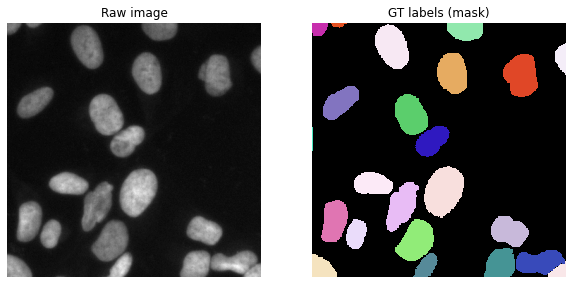

In [7]:
plt.figure(figsize=(10,8))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap, interpolation="nearest"); plt.axis('off'); plt.title('GT labels (mask)')
None;

<div class="alert alert-block alert-info"><h2>Exercise</h2> 
    

An crucial part in any DL workflow is to get to know your data!
    
Please compute some object level statistics for the training dataset, e.g. plot the histogram for the following properties:

1) intensity range per raw image 
    
2) number of objects per label images 
    
3) average area of objects per label image     
    
For the later part, `skimage.measure.regionprops` is your friend!
        
</div>

## Fitting ground-truth labels with star-convex polygons


Before we train a stardist model, lets check whether its core assumption (roundish object) is appropriate. To that end, we will compute the best possible star-convex approximation for a certain number of rays and check whether it is reasonable.

In [8]:
n_rays = [2**i for i in range(2,8)]
print(n_rays)

[4, 8, 16, 32, 64, 128]


### Example image reconstructed with various number of rays

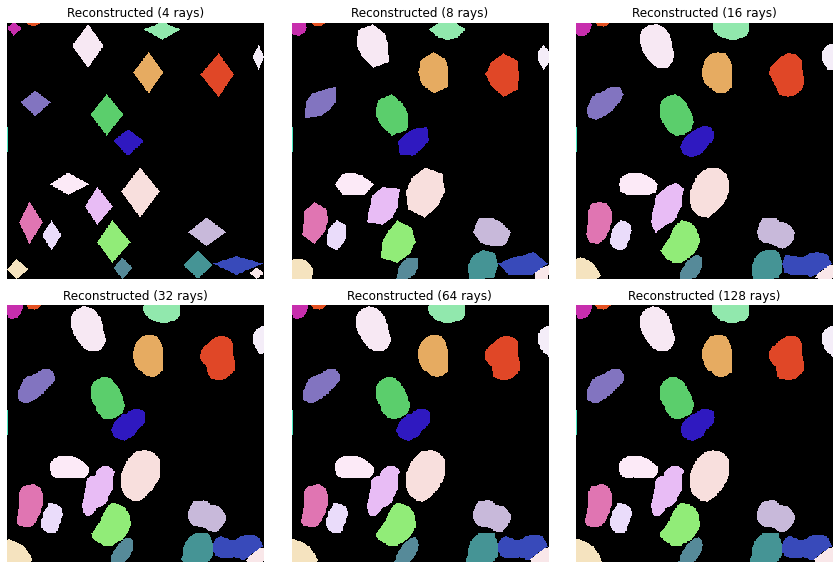

In [9]:
fig, ax = plt.subplots(2,3, figsize=(12,8))
for a,r in zip(ax.flat,n_rays):
    a.imshow(relabel_image_stardist(lbl, n_rays=r), cmap=lbl_cmap, interpolation="nearest")
    a.set_title('Reconstructed (%d rays)' % r)
    a.axis('off')
plt.tight_layout();

#### Mean IoU for different number of rays

In [10]:
scores = []
for r in tqdm(n_rays):
    Y_reconstructed = [relabel_image_stardist(lbl, n_rays=r) for lbl in Y_small]
    mean_iou = matching_dataset(Y_small, Y_reconstructed, thresh=0, show_progress=False).mean_true_score
    scores.append(mean_iou)

100%|████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.83it/s]


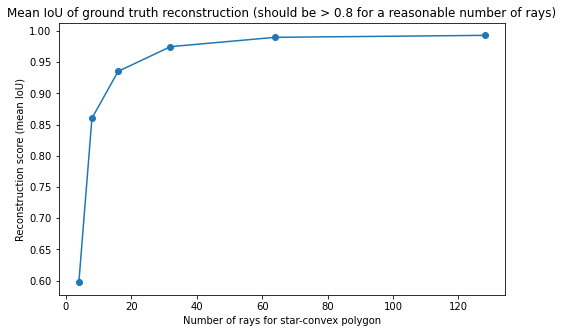

In [11]:
plt.figure(figsize=(8,5))
plt.plot(n_rays, scores, 'o-')
plt.xlabel('Number of rays for star-convex polygon')
plt.ylabel('Reconstruction score (mean IoU)')
plt.title("Mean IoU of ground truth reconstruction (should be > 0.8 for a reasonable number of rays)")
None;

# Training 


Training data (for input `X` with associated label masks `Y`) can be provided via lists of numpy arrays, where each image can have a different size. Alternatively, a single numpy array can also be used if all images have the same size.  
Input images can either be two-dimensional (single-channel) or three-dimensional (multi-channel) arrays, where the channel axis comes last. Label images need to be integer-valued.

In [12]:
fX = sorted(Path('data/dsb2018/train/images/').glob('*.tif'))
fY = sorted(Path('data/dsb2018/train/masks').glob('*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(fX,fY))
print(f"{len(fX)} files found")

447 files found


In [13]:
X = list(map(imread,map(str,tqdm(fX))))
Y = list(map(imread,map(str,tqdm(fY))))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

100%|███████████████████████████████████████████████████| 447/447 [00:02<00:00, 188.62it/s]


Normalize images and fill small label holes.

In [14]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|███████████████████████████████████████████████████| 447/447 [00:01<00:00, 297.07it/s]


<div class="alert alert-block alert-info"><h2>Exercise</h2> 
    
Can you guess what `normalize` does? Why don't we simply divide by the maximal possible pixel value (e.g. 65535 for 16 bit cameras) or the maximum of each image? 
        
</div>

Split into train and validation datasets.

In [15]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 447
- training:       380
- validation:      67


Training data consists of pairs of input image and label instances.

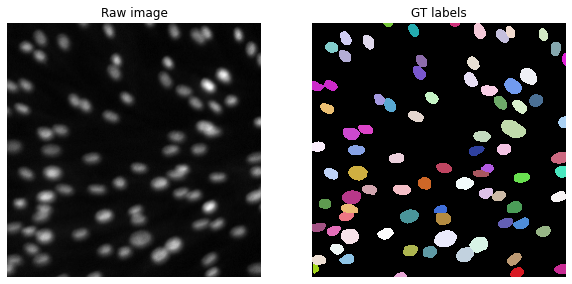

In [16]:
i = min(9, len(X)-1)
img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if img.ndim==2 else img[...,:3]
plt.figure(figsize=(10,8))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap, interpolation="nearest"); plt.axis('off'); plt.title('GT labels')
None;

## Configuration

A `StarDist2D` model is specified via a `Config2D` object (essentially a `dict` of properties)

In [17]:
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class predection (use None to disable)
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
   

We will simply use 32 rays, which should be good enough. Additonally, we can set `grid=(2,2)` which only predicts every second pixel in teh final result (which vastly speeds everything up, and is reasonable if objects are larger than 2px)

In [18]:
conf = Config2D (
    n_rays       = 32,
    grid         = (2,2),
    n_channel_in = 1,
)
print(conf)
vars(conf)

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=1, n_channel_out=33, n_classes=None, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_class_weights=(1, 1), train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_sample_cache=True, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), unet_prefix='', 

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,


In [19]:
model = StarDist2D(conf, name='stardist', basedir='models/2_instance_segmentation_2D')

2022-07-16 10:03:00.908502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-16 10:03:00.951632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-16 10:03:00.951898: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Using default values: prob_thresh=0.5, nms_thresh=0.4.


2022-07-16 10:03:00.953620: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-16 10:03:00.953936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-16 10:03:00.954162: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-16 10:03:00.954361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

Check if the neural network has a large enough field of view to see up to the boundary of most objects.

In [20]:
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))

if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")
else:
    print(f"All good! (object sizes {median_size} fit into field of view {fov} of the neural network)")


2022-07-16 10:03:01.858167: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-16 10:03:03.216497: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-07-16 10:03:05.596289: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


All good! (object sizes [17.5 18. ] fit into field of view [94 92] of the neural network)


## Augmentation


You can define a function/callable that applies augmentation to each batch of the data generator.  
We here use an `augmenter` that applies random rotations, flips, and intensity changes, which are typically sensible for (2D) microscopy images:

In [21]:
def random_fliprot(img, mask): 
    axes = tuple(range(img.ndim)) 
    perm = np.random.permutation(axes)
    img = img.transpose(perm) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand()>.5:
            img = np.flip(img,axis = ax)
            mask = np.flip(mask,axis = ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2)
    return img


def augmenter(img,mask):
    """Augmentation for image,mask"""
    img, mask = random_fliprot(img, mask)
    img = random_intensity_change(img)
    return img, mask

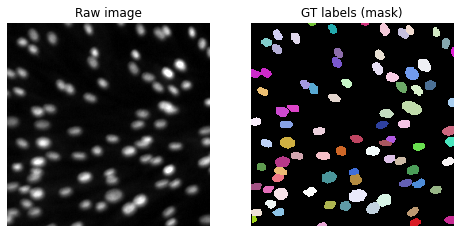

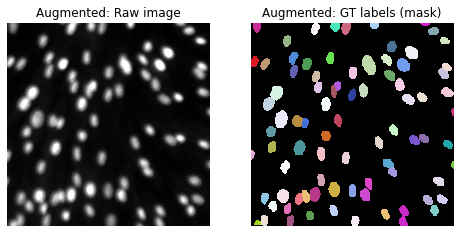

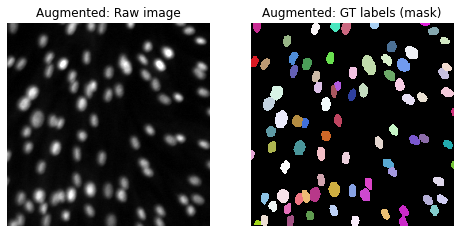

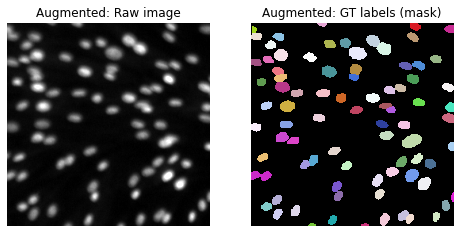

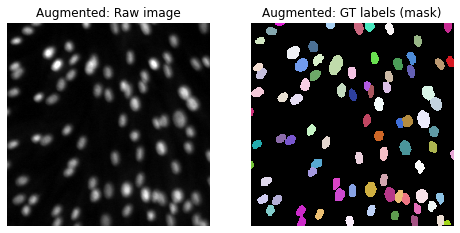

In [22]:
plt.figure(figsize=(8,5))
plt.subplot(121); plt.imshow(img,cmap='gray', clim = (0,1));   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap, interpolation="nearest"); plt.axis('off'); plt.title('GT labels (mask)')
  
for _ in range(4):
    plt.figure(figsize=(8,5))
    x,y = augmenter(img, lbl)
    plt.subplot(121); plt.imshow(x,cmap='gray', clim = (0,1));   plt.axis('off'); plt.title('Augmented: Raw image')
    plt.subplot(122); plt.imshow(y,cmap=lbl_cmap, interpolation="nearest"); plt.axis('off'); plt.title('Augmented: GT labels (mask)')
None;

<div class="alert alert-block alert-info"><h2>Exercise</h2> 
    

1) Often times adding noise as additional augmentation leads to a robuster model. Can you incoporate such an augmentation in the `augmenter` function?
    
2) If you want to add even more augmentations (and see whether model performance changes), you can use the stardist `augmend` package: https://github.com/stardist/augmend . Feel free to play with it!
        
</div>

## Model Training

Typically, a 2D model will be converged after .5-2hr training, which we wont do now. We therefore set the number of `epochs` and `steps_per_epoch` to smaller values. 

In [23]:
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
                epochs=100, steps_per_epoch=50)


Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function _gcd_import at 0x7f3ddde1eb00>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function _gcd_import at 0x7f3ddde1eb00>. Note that functions defined in certain environments, like the i

2022-07-16 10:03:10.811790: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-07-16 10:03:11.962120: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


50/50 [==============================] - 6s 43ms/step - loss: 2.6953 - prob_loss: 0.3935 - dist_loss: 11.5086 - prob_kld: 0.3102 - dist_relevant_mae: 11.5082 - dist_relevant_mse: 240.9006 - dist_dist_iou_metric: 0.0979 - val_loss: 2.0061 - val_prob_loss: 0.2510 - val_dist_loss: 8.7753 - val_prob_kld: 0.1802 - val_dist_relevant_mae: 8.7747 - val_dist_relevant_mse: 165.2127 - val_dist_dist_iou_metric: 0.2212


2022-07-16 10:03:14.681549: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


Epoch 2/100
50/50 [==============================] - 1s 28ms/step - loss: 1.8229 - prob_loss: 0.3272 - dist_loss: 7.4783 - prob_kld: 0.2574 - dist_relevant_mae: 7.4776 - dist_relevant_mse: 119.0115 - dist_dist_iou_metric: 0.2935 - val_loss: 1.7595 - val_prob_loss: 0.2870 - val_dist_loss: 7.3626 - val_prob_kld: 0.2162 - val_dist_relevant_mae: 7.3619 - val_dist_relevant_mse: 123.3705 - val_dist_dist_iou_metric: 0.2753
Epoch 3/100
50/50 [==============================] - 1s 25ms/step - loss: 1.5933 - prob_loss: 0.3049 - dist_loss: 6.4418 - prob_kld: 0.2230 - dist_relevant_mae: 6.4409 - dist_relevant_mse: 86.7803 - dist_dist_iou_metric: 0.3558 - val_loss: 1.6420 - val_prob_loss: 0.2791 - val_dist_loss: 6.8146 - val_prob_kld: 0.2083 - val_dist_relevant_mae: 6.8138 - val_dist_relevant_mse: 106.2295 - val_dist_dist_iou_metric: 0.2971
Epoch 4/100
50/50 [==============================] - 1s 25ms/step - loss: 1.5810 - prob_loss: 0.2834 - dist_loss: 6.4881 - prob_kld: 0.2066 - dist_relevant_mae: 

Epoch 22/100
50/50 [==============================] - 1s 25ms/step - loss: 0.6273 - prob_loss: 0.0983 - dist_loss: 2.6453 - prob_kld: 0.0205 - dist_relevant_mae: 2.6448 - dist_relevant_mse: 20.9417 - dist_dist_iou_metric: 0.6690 - val_loss: 0.6956 - val_prob_loss: 0.0896 - val_dist_loss: 3.0303 - val_prob_kld: 0.0188 - val_dist_relevant_mae: 3.0298 - val_dist_relevant_mse: 27.2830 - val_dist_dist_iou_metric: 0.6360
Epoch 23/100
50/50 [==============================] - 1s 24ms/step - loss: 0.6669 - prob_loss: 0.0975 - dist_loss: 2.8469 - prob_kld: 0.0204 - dist_relevant_mae: 2.8464 - dist_relevant_mse: 24.4092 - dist_dist_iou_metric: 0.6572 - val_loss: 0.6358 - val_prob_loss: 0.0858 - val_dist_loss: 2.7500 - val_prob_kld: 0.0150 - val_dist_relevant_mae: 2.7494 - val_dist_relevant_mse: 20.5036 - val_dist_dist_iou_metric: 0.6738
Epoch 24/100
50/50 [==============================] - 1s 24ms/step - loss: 0.6285 - prob_loss: 0.0970 - dist_loss: 2.6574 - prob_kld: 0.0185 - dist_relevant_mae: 

Epoch 42/100
50/50 [==============================] - 1s 22ms/step - loss: 0.5953 - prob_loss: 0.0958 - dist_loss: 2.4972 - prob_kld: 0.0182 - dist_relevant_mae: 2.4967 - dist_relevant_mse: 20.2039 - dist_dist_iou_metric: 0.6923 - val_loss: 0.5350 - val_prob_loss: 0.0846 - val_dist_loss: 2.2519 - val_prob_kld: 0.0138 - val_dist_relevant_mae: 2.2514 - val_dist_relevant_mse: 15.9778 - val_dist_dist_iou_metric: 0.7145
Epoch 43/100
50/50 [==============================] - 1s 22ms/step - loss: 0.5780 - prob_loss: 0.0985 - dist_loss: 2.3974 - prob_kld: 0.0207 - dist_relevant_mae: 2.3969 - dist_relevant_mse: 17.9772 - dist_dist_iou_metric: 0.7026 - val_loss: 0.5733 - val_prob_loss: 0.0861 - val_dist_loss: 2.4362 - val_prob_kld: 0.0153 - val_dist_relevant_mae: 2.4357 - val_dist_relevant_mse: 19.2557 - val_dist_dist_iou_metric: 0.6902
Epoch 44/100
50/50 [==============================] - 1s 22ms/step - loss: 0.6222 - prob_loss: 0.0959 - dist_loss: 2.6319 - prob_kld: 0.0173 - dist_relevant_mae: 

Epoch 62/100
50/50 [==============================] - 1s 22ms/step - loss: 0.5001 - prob_loss: 0.0957 - dist_loss: 2.0224 - prob_kld: 0.0173 - dist_relevant_mae: 2.0218 - dist_relevant_mse: 12.3997 - dist_dist_iou_metric: 0.7361 - val_loss: 0.5184 - val_prob_loss: 0.0837 - val_dist_loss: 2.1738 - val_prob_kld: 0.0129 - val_dist_relevant_mae: 2.1733 - val_dist_relevant_mse: 14.2135 - val_dist_dist_iou_metric: 0.7175
Epoch 63/100
50/50 [==============================] - 1s 22ms/step - loss: 0.4866 - prob_loss: 0.0930 - dist_loss: 1.9683 - prob_kld: 0.0155 - dist_relevant_mae: 1.9679 - dist_relevant_mse: 12.8004 - dist_dist_iou_metric: 0.7435 - val_loss: 0.4987 - val_prob_loss: 0.0848 - val_dist_loss: 2.0695 - val_prob_kld: 0.0140 - val_dist_relevant_mae: 2.0690 - val_dist_relevant_mse: 12.3022 - val_dist_dist_iou_metric: 0.7366
Epoch 64/100
50/50 [==============================] - 1s 21ms/step - loss: 0.4995 - prob_loss: 0.0920 - dist_loss: 2.0375 - prob_kld: 0.0155 - dist_relevant_mae: 

Epoch 82/100
50/50 [==============================] - 1s 22ms/step - loss: 0.4485 - prob_loss: 0.0879 - dist_loss: 1.8030 - prob_kld: 0.0159 - dist_relevant_mae: 1.8026 - dist_relevant_mse: 10.3606 - dist_dist_iou_metric: 0.7547 - val_loss: 0.4583 - val_prob_loss: 0.0848 - val_dist_loss: 1.8678 - val_prob_kld: 0.0140 - val_dist_relevant_mae: 1.8673 - val_dist_relevant_mse: 11.5740 - val_dist_dist_iou_metric: 0.7579
Epoch 83/100
50/50 [==============================] - 1s 22ms/step - loss: 0.5061 - prob_loss: 0.1005 - dist_loss: 2.0284 - prob_kld: 0.0174 - dist_relevant_mae: 2.0279 - dist_relevant_mse: 13.2175 - dist_dist_iou_metric: 0.7478 - val_loss: 0.5013 - val_prob_loss: 0.0843 - val_dist_loss: 2.0852 - val_prob_kld: 0.0135 - val_dist_relevant_mae: 2.0848 - val_dist_relevant_mse: 12.9638 - val_dist_dist_iou_metric: 0.7206
Epoch 84/100
50/50 [==============================] - 1s 22ms/step - loss: 0.4520 - prob_loss: 0.0881 - dist_loss: 1.8196 - prob_kld: 0.0151 - dist_relevant_mae: 

## Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [24]:
model.optimize_thresholds(X_val[::5], Y_val[::5])

2022-07-16 10:05:21.815323: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-07-16 10:05:21.827832: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-07-16 10:05:22.239705: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-07-16 10:05:22.253377: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Alloc

Using optimized values: prob_thresh=0.49753, nms_thresh=0.4.
Saving to 'thresholds.json'.


{'prob': 0.49753014478388424, 'nms': 0.4}

# 3. Prediction

We now load images from the sub-folder `test` that have not been used during training.

In [25]:
fXt = sorted(Path('data/dsb2018/test/images/').glob('*.tif'))
print(f"{len(fXt)} files found")
Xt = list(map(imread,map(str,tqdm(fXt))))

n_channel = 1 if Xt[0].ndim == 2 else Xt[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

50 files found


100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 299.16it/s]


## Prediction

Make sure to normalize the input image beforehand or supply a `normalizer` to the prediction function.

Calling `model.predict_instances` will
- predict object probabilities and star-convex polygon distances (see `model.predict` if you want those)
- perform non-maximum suppression (with overlap threshold `nms_thresh`) for polygons above object probability threshold `prob_thresh`.
- render all remaining polygon instances in a label image
- return the label instances image and also the details (coordinates, etc.) of all remaining polygons

In [26]:
img = normalize(Xt[16], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img, verbose = True)

predicting instances with nms_thresh = 0.4
non-maximum suppression...
keeping 16/2333 polyhedra
NMS took 0.0101 s
Non Maximum Suppression (2D) ++++ 
NMS: n_polys    = 2333 
NMS: n_rays     = 32  
NMS: thresh     = 0.400 
NMS: use_bbox   = 1
NMS: use_kdtree = 1
NMS: using OpenMP with 4 thread(s)
NMS: building kdtree...
NMS: starting suppression loop
|################################################  | [97 % suppressed]

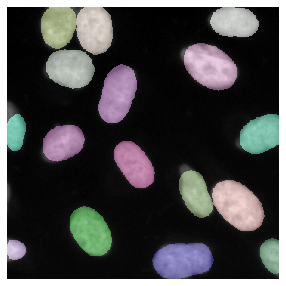

In [27]:
plt.figure(figsize=(5,5))
plt.imshow(img if img.ndim==2 else img[...,:3], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, interpolation="nearest", alpha=0.5)
plt.axis('off');

## More example results

In [28]:
def example(model, i, show_dist=True):
    img = normalize(Xt[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)

    plt.figure(figsize=(13,10))
    img_show = img if img.ndim==2 else img[...,:3]
    coord, points, prob = details['coord'], details['points'], details['prob']
    plt.subplot(121); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    a = plt.axis()
    _draw_polygons(coord, points, prob, show_dist=show_dist)
    plt.axis(a)
    plt.subplot(122); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    plt.imshow(labels, cmap=lbl_cmap, interpolation="nearest", alpha=0.5)
    plt.tight_layout()
    plt.show()

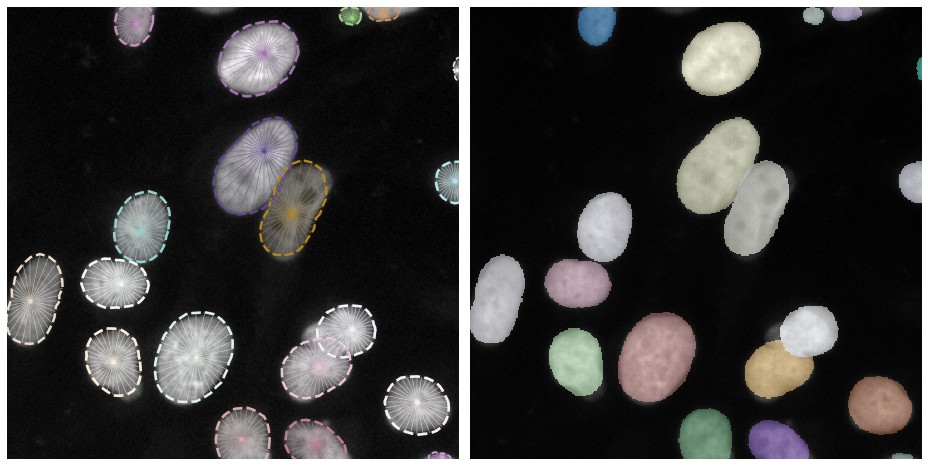

In [29]:
example(model, 42)

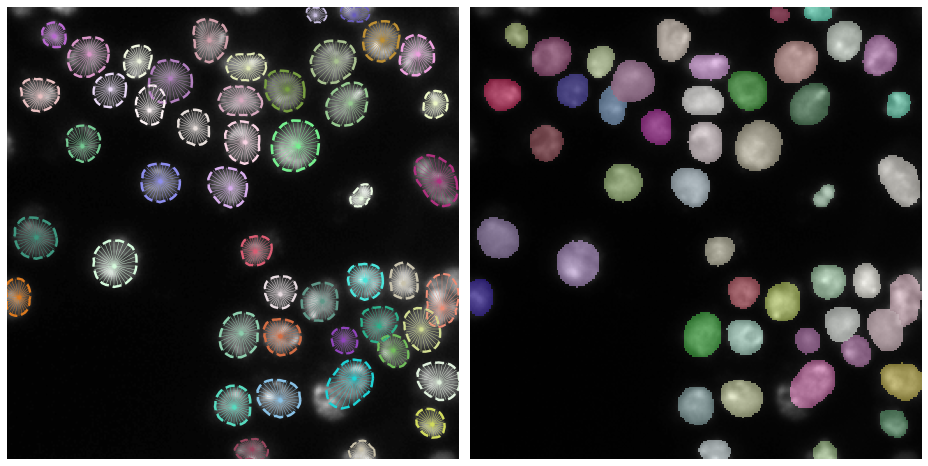

In [30]:
example(model, 1)

2022-07-16 10:05:29.919742: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-07-16 10:05:29.956001: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-07-16 10:05:29.981669: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


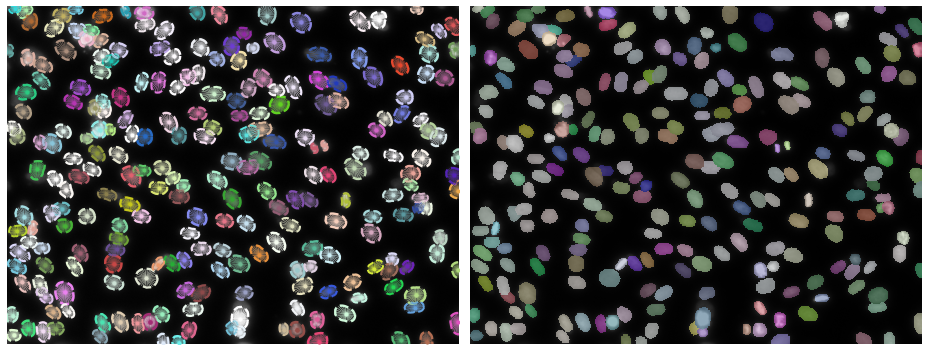

In [31]:
example(model, 15)

## Evaluation and Detection Performance

Besides the losses and metrics during training, we can also quantitatively evaluate the actual detection/segmentation performance on the validation data by considering objects in the ground truth to be correctly matched if there are predicted objects with overlap (here [intersection over union (IoU)](https://en.wikipedia.org/wiki/Jaccard_index)) beyond a chosen IoU threshold $\tau$.

The corresponding matching statistics (average overlap, accuracy, recall, precision, etc.) are typically of greater practical relevance than the losses/metrics computed during training (but harder to formulate as a loss function). 
The value of $\tau$ can be between 0 (even slightly overlapping objects count as correctly predicted) and 1 (only pixel-perfectly overlapping objects count) and which $\tau$ to use depends on the needed segmentation precision/application.

Please see the Wikipedia page on [Sensitivity and specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) for definitions of the abbreviations used in the evaluation below. Note that `mean_true_score` refers to the average overlap (IoU) of all true positives (tp), i.e. correctly predicted objects in terms of the chosen overlap threshold.

First predict the labels for all validation images:

In [32]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

100%|██████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.11it/s]


Choose several IoU thresholds $\tau$ that might be of interest and for each compute matching statistics for the validation data.

In [33]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.42it/s]


Example: Print all available matching statistics for $\tau=0.5$

In [34]:
stats[taus.index(0.5)]

DatasetMatching(criterion='iou', thresh=0.5, fp=118, tp=2245, fn=298, precision=0.9500634786288616, recall=0.8828155721588675, accuracy=0.8436677940623826, f1=0.9152058703628211, n_true=2543, n_pred=2363, mean_true_score=0.7304854456758668, mean_matched_score=0.8274496607366277, panoptic_quality=0.7572867869358864, by_image=False)

Plot the matching statistics and the number of true/false positives/negatives as a function of the IoU threshold $\tau$. 

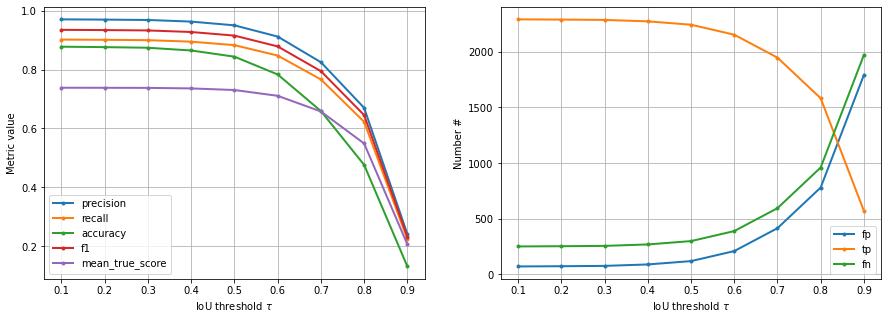

In [35]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

<div class="alert alert-block alert-info"><h2>Exercise</h2> 
    
1) Rerun the training while using only few (e.g. 10) images. How much does accuracy drop? How low can you go?  
        
2) If you want, you can install the stardist napari plugin (https://github.com/stardist/stardist-napari) on your local machine, transfer the model folder, and apply it to images that you have.
</div>